In [1]:
! pip install av
! pip install ffmpeg-python
! pip install opencv-python
! pip install mediapipe
! pip install pandas

# start


## import

In [2]:
import cv2 as cv
import mediapipe as mp
import pandas as pd
import os
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import ffmpeg


## skeleton to csv

In [3]:
def skeleton_csv(video_path ='', output_video_path ='', make_video=True, output_video_name='skeleton_video'):
    try:
        # Initialize MediaPipe Pose
        mp_pose = mp.solutions.pose
        mp_drawing = mp.solutions.drawing_utils
        pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)

        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Unable to open video file at path:", video_path)
            return None
        all_landmarks = []

        # Get video properties for output video
        frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv.CAP_PROP_FPS)

        # Define the codec and create VideoWriter object
        out = None
        if make_video:
            output_video_name = output_video_name + '.mp4'
            output_video_path = os.path.join(output_video_path, output_video_name)
            out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                # Draw the pose annotation on the image
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Extract and store landmarks
                ref_x = (results.pose_landmarks.landmark[23].x + results.pose_landmarks.landmark[24].x) / 2
                ref_y = (results.pose_landmarks.landmark[23].y + results.pose_landmarks.landmark[24].y) / 2
                ref_z = (results.pose_landmarks.landmark[23].z + results.pose_landmarks.landmark[24].z) / 2

                landmarks = []
                for lm in results.pose_landmarks.landmark:
                    rel_x, rel_y, rel_z = lm.x - ref_x, lm.y - ref_y, lm.z - ref_z
                    landmarks.extend([rel_x, rel_y, rel_z, lm.visibility])
                all_landmarks.append(landmarks)

                if make_video:
                    out.write(image)  # Write the frame with pose to the output video

        cap.release()
        if make_video:
            out.release()

        df = pd.DataFrame(all_landmarks)

        #return df
        skeletons_tensor = torch.tensor(all_landmarks, dtype=torch.float32)
        print(skeletons_tensor.shape)
        return skeletons_tensor
    except:
        return torch.Tensor([1])  # 오류 발생 시 기본 텐서 반환


In [4]:
def skeleton_csv90frames(video_path='', output_video_path='', make_video=True, output_video_name='skeleton_video'):

    try:
        ffmpeg.probe(video_path)
    except ffmpeg.Error as e:
        print(f"FFmpeg error for file {video_path}: {e.stderr}")
        return torch.Tensor([1])  # Return a default tensor if FFmpeg cannot read the file


    # Initialize MediaPipe Pose
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)

    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file at path:", video_path)
        return torch.Tensor([1]) # prevent from None going in to dataset (if not, learning stops)
    all_landmarks = []

    # Get video properties for output video
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    out = None
    if make_video: 
        output_video_name = output_video_name + '.mp4'
        output_video_path = os.path.join(output_video_path, output_video_name)
        out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    frame_count = 0
    max_frames = 10000  # Process only first 90 frames

    while cap.isOpened() and frame_count < max_frames:
        success, image = cap.read()
        if not success:
            break

        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            # Draw the pose annotation on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Extract and store landmarks
            ref_x = (results.pose_landmarks.landmark[23].x + results.pose_landmarks.landmark[24].x) / 2
            ref_y = (results.pose_landmarks.landmark[23].y + results.pose_landmarks.landmark[24].y) / 2
            ref_z = (results.pose_landmarks.landmark[23].z + results.pose_landmarks.landmark[24].z) / 2

            landmarks = []
            for lm in results.pose_landmarks.landmark:
                rel_x, rel_y, rel_z = lm.x - ref_x, lm.y - ref_y, lm.z - ref_z
                landmarks.extend([rel_x, rel_y, rel_z, lm.visibility])
            all_landmarks.append(landmarks)

            if make_video:
                out.write(image)  # Write the frame with pose to the output video

        frame_count += 1  # Increment frame count

    cap.release()
    if make_video:
        out.release()


    skeletons_tensor = torch.tensor(all_landmarks, dtype=torch.float32)
    if skeletons_tensor is None:
        skeletons_tensor = torch.Tensor([1]) # Prevent from None type return
    return skeletons_tensor

# Model

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Get dataset - video

In [6]:
class UCF4Dataset(Dataset):
    def __init__(self, directory):
        ds_store_path = os.path.join(directory, '.DS_Store')
        if os.path.exists(ds_store_path):
            os.remove(ds_store_path)
        self.directory = directory
        self.classes = os.listdir(directory)
        self.data = []

        # ignore ._ files  (Mac os system folder)
        for class_name in self.classes:
            class_path = os.path.join(directory, class_name)
            for video in os.listdir(class_path):
                if not video.startswith('.'):
                    self.data.append((os.path.join(class_path, video), class_name))
        #print("Classes name : ",self.classes)
        print(self.data)
        # MediaPipe 초기화
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(static_image_mode=False, model_complexity=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]
        print("video path",video_path)
        if os.path.exists(video_path):
            print(f'{video_path} 경로가 존재합니다.')
        else:
            print(f'{video_path} 경로가 존재하지 않습니다.')
        print("class name",class_name)
        skeletons = skeleton_csv90frames(video_path=video_path,make_video=False)

        label = self.classes.index(class_name)
        return skeletons, label

## Dataset Path

In [7]:
import os

# 데이터셋 및 데이터 로더 초기화
#dataset_path = '..\\data\\UCF101\\UCF4 small\\'  # 추출된 데이터셋의 경로
#dataset_path = 'd:\\5CODE\\-ActionClass\\data\\UCF101/UCF4 small\\'
#dataset_path = r'D:\5CODE\-ActionClass\data\UCF101\UCF4 small\'
dataset_path = '../data/UCF101/UCF4 small/'


if os.path.exists(dataset_path):
    print(f'{dataset_path} 경로가 존재합니다.')
else:
    print(f'{dataset_path} 경로가 존재하지 않습니다.')


../data/UCF101/UCF4 small/ 경로가 존재합니다.


In [8]:
dataset = UCF4Dataset(dataset_path)


# 데이터셋 크기 정의
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)  # 70%를 훈련 데이터로 사용
val_size = int(dataset_size * 0.15)  # 15%를 검증 데이터로 사용
test_size = dataset_size - train_size - val_size  # 나머지를 테스트 데이터로 사용

# Split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create Dataset
Batch_Size = 1

train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_Size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True)

[('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c01.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi', 'WalkingWithDog'), ('../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01

I0000 00:00:1701316572.966705       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


In [9]:
print(os.getcwd())

/Volumes/FOREVER/5CODE/-ActionClass/01Deep


In [10]:
len(train_loader),len(val_loader),len(test_loader)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(28, 6, 6)

# Parameter

In [11]:
# Define the LSTM model
input_size = 132  # Adjust based on your skeleton data
hidden_size = 128
num_layers = 2
num_classes = 4  # Adjust based on the number of classes in your dataset
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5, min_lr=0.0001)

In [13]:
# Initialize variables to track the best model
best_val_loss = float('inf')
best_model = None

# Trackers for graph
train_losses = []
val_losses = []


In [14]:
from tqdm import tqdm

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for skeletons, labels in train_loader:
        try:
            outputs = model(skeletons)
        except:
            #print("Error during model inference in training")
            continue  # Skip to the next batch

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for skeletons, labels in val_loader:
            try:
                outputs = model(skeletons)
            except:
                #print("Error during model inference in validation")
                continue  # Skip to the next batch

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model.state_dict()

    # Adjust learning rate
    scheduler.step(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


# Save the best model
torch.save(best_model, '../OUTPUT/ucf101_model.pth')

video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316573.592748       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316576.231153       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316581.492802       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316582.420452       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316583.864398       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316586.674937       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316588.743932       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316589.844836       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316592.664933       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316594.684021       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316596.575013       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316601.890490       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316604.902053       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316608.270793       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316611.663299       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316614.854503       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316618.701833       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316623.515511       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316626.823449       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316629.727292       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316634.293546       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316637.374888       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316641.768497       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316644.695707       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316647.438567       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316651.971384       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316654.800979       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316659.799855       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316662.809769       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316667.675505       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316670.609594       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316673.792676       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi 경로가 존재합니다.
class name Punch


Context leak detected, msgtracer returned -1
I0000 00:00:1701316676.581204       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316677.239271       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Epoch [1/5], Train Loss: 1.2729556092194148, Val Loss: 0.6757810314496359
video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316682.433490       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316685.732890       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316687.906626       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316691.333163       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316692.456802       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316696.381668       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316699.624088       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316701.850281       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316706.944310       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316710.351949       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316713.949932       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316717.244050       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316720.483682       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316721.709731       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi 경로가 존재합니다.
class name Biking


Context leak detected, msgtracer returned -1
I0000 00:00:1701316726.710153       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316729.734034       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316732.635624       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316738.703068       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316742.088768       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316747.443896       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316748.999455       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316754.494943       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316757.867867       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316761.199811       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316765.539545       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316769.402938       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316773.462427       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316779.388737       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316784.449788       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316787.437429       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316790.400911       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi 경로가 존재합니다.
class name WalkingWithDog


Context leak detected, msgtracer returned -1
I0000 00:00:1701316791.067218       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316797.135456       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316800.222964       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Epoch [2/5], Train Loss: 1.0352794506720133, Val Loss: 0.7784907619158427
video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316805.900488       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316808.055067       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316809.500935       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316814.459700       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316818.119001       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316819.201972       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316826.229490       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316831.951701       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316834.500753       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316837.866980       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316841.380455       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316844.228747       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316846.943433       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316850.760682       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi 경로가 존재합니다.
class name WalkingWithDog


Context leak detected, msgtracer returned -1
I0000 00:00:1701316856.369205       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316860.316361       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316863.955137       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316868.922361       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316872.287123       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316875.130828       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316878.063759       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316884.346991       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316889.422096       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316892.777224       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316895.761749       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316899.146333       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316902.504057       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316905.502488       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316907.033636       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316907.672635       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi 경로가 존재합니다.
class name Biking


Context leak detected, msgtracer returned -1
I0000 00:00:1701316912.231054       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316914.961738       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316917.775694       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316921.111798       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Epoch [3/5], Train Loss: 0.9403689865555082, Val Loss: 0.6138244767983755
video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316925.504671       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316928.722100       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316931.581003       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316933.810901       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316939.172686       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316940.224823       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316943.396689       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316945.940925       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316951.529308       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316956.089558       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316961.177044       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316963.323518       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316966.441753       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi 경로가 존재합니다.
class name WalkingWithDog


Context leak detected, msgtracer returned -1
I0000 00:00:1701316969.567799       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316973.194872       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316976.554898       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701316981.608319       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316986.897599       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701316990.509657       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701316992.529251       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316995.836873       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701316999.496984       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317002.435959       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317005.335695       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317009.957069       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317011.214417       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317013.670176       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317018.455918       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317021.980841       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317026.602684       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi 경로가 존재합니다.
class name Biking


Context leak detected, msgtracer returned -1
I0000 00:00:1701317029.598037       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317032.506300       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317035.266157       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317036.195772       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Epoch [4/5], Train Loss: 0.8773567527532578, Val Loss: 0.6709896425406138
video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c05.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317041.358112       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c06.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317042.468931       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317046.514839       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317048.936340       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317054.118130       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317057.137998       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c01.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317058.373433       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c07.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317061.117974       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317064.335995       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c04.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317067.627725       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c05.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317072.554742       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317077.029502       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c04.avi 경로가 존재합니다.
class name WalkingWithDog


Context leak detected, msgtracer returned -1
I0000 00:00:1701317081.836234       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c03.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317085.576881       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317089.077436       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317091.449596       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c02.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317093.177270       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317099.916871       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c03.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317103.622862       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c04.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317109.072951       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c05.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317112.737290       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g03_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317116.357957       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c05.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317120.027317       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c06.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317124.007921       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317127.194677       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317133.685541       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317137.414803       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c03.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317139.811847       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317143.136593       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c06.avi 경로가 존재합니다.
class name WalkingWithDog


Context leak detected, msgtracer returned -1
I0000 00:00:1701317146.764565       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317152.548941       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c01.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317153.391537       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g02_c04.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317156.875152       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g01_c02.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317160.310907       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Epoch [5/5], Train Loss: 0.7759365801300321, Val Loss: 0.9576490223407745


## Train Val Graph

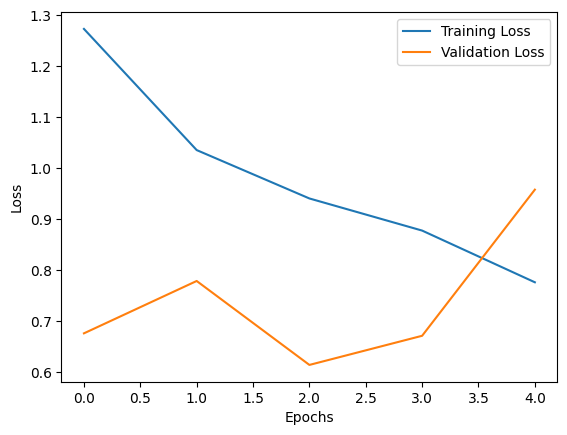

In [15]:
# Plotting train and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Test loop for accuracy
correct = 0
total = 0
with torch.no_grad():
    for skeletons, labels in test_loader:
        try:
            outputs = model(skeletons)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        except:
            pass

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

video path ../data/UCF101/UCF4 small/Biking/v_Biking_g01_c02.avi
../data/UCF101/UCF4 small/Biking/v_Biking_g01_c02.avi 경로가 존재합니다.
class name Biking


I0000 00:00:1701317166.314019       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c01.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c01.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317169.309517       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c02.avi
../data/UCF101/UCF4 small/BoxingPunchingBag/v_BoxingPunchingBag_g01_c02.avi 경로가 존재합니다.
class name BoxingPunchingBag


I0000 00:00:1701317174.008711       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g02_c03.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g02_c03.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317177.601282       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c01.avi
../data/UCF101/UCF4 small/WalkingWithDog/v_WalkingWithDog_g02_c01.avi 경로가 존재합니다.
class name WalkingWithDog


I0000 00:00:1701317178.794375       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


video path ../data/UCF101/UCF4 small/Punch/v_Punch_g01_c04.avi
../data/UCF101/UCF4 small/Punch/v_Punch_g01_c04.avi 경로가 존재합니다.
class name Punch


I0000 00:00:1701317183.358380       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


Accuracy on test set: 33.333333333333336%
